# Expérience basique
## filbench : filemicro_seqread
### Obtenir le seuil de la `high` limite
#### Description
L'expérience présente est la suite de l'expérience "Tester la `high` limite". Le but de celle-ci sera de trouver le seuil à partir duquel la `high` limite ruine les performances.

Le benchmark `filebench` sera donc utilisé avec la charge de travail `filemicro_sequread` pour un fichier de 1024MB par pas de 1MB.

#### Environnement
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 2GB de mémoire et 2 coeurs. 

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

#### Résultat attendus
Puisque le fichier lu fait 1024MB une `high` limite inférieure à cette valeur devrait faire baisser les performances du benchmark.

Néanmoins il faut aussi de la mémoire pour stocker les autres données du benchmark (code, etc.) donc le seuil devrait se trouver un peu plus au-dessus de 1024MB.

#### Algorithme de l'expérience
```bash
#! /usr/bin/env bash
# SPDX-License-Identifier: MPL-2.0
# The sizes we want to test. They are arbirtrary/dichotomy set.
sizes='850M 900M 1000M 1025M 1037M 1040M 1043M 1050M 1100M'

# Launch filebench container as detached and get its id.
id=$(docker run -d filebench)

for s in $sizes; do
	echo "Size is: $s."
	# Change the high limit.
	echo $s > /sys/fs/cgroup/memory/docker/$id/memory.high_limit_in_bytes

	# And run the container.
	docker exec $id ./filebench -f workloads/filemicro_seqread.f
done

docker stop $id
docker rm $id
```

#### Résultats obtenus
Le graphique suivant montre le nombre d'opérations par seconde en fonction de la `high` limite :

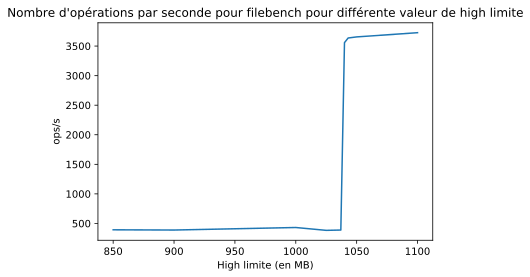

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

# Read the csv file and get the values.
df = pd.read_csv('thresold_high_limit.csv', ';')
values = df.values

# Axis and figure initialization.
fig, ax = plt.subplots()
# loc permits to get some data in a DataFrame. Here the notation [:, 'key'] 
# to get the values for the given keys.
ax.plot(df.loc[:, 'high_limit'].values, df.loc[:, 'ops/s'].values)
ax.set_ylabel('ops/s')
ax.set_xlabel('High limite (en MB)')
ax.set_title("Nombre d'opérations par seconde pour filebench pour différente valeur de high limite")

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Les écart-types ne sont pas présents car l'expérience précédente a montré que les résultats étaient stables.

La forme de la courbe montre clairement qu'il y a un seuil en dessous duquel la `high` limite dégrade fortement les performances. Ce seuil semble se situer après 1037MB et avant 1040MB.

La forme de la courbe est totalement normale car le fichier est lu séquentiellement. À partir du moment où toutes les données tiennent en mémoire les performances sont excellentes. Avant elles sont très mauvaises. Il n'est donc pas forcément utile d'essayer d'obtenir une valeur très précise.

#### Conclusion
Pour cette expérience il existe clairement un seuil à partir en dessous duquel la `high` limite dégrade fortement les performances.

Ce seuil se situe aux environs de 1024MB puisque le fichier lu fait 1024MB mais il faut compter un peu plus pour les autres données de `filebench` (son code par exemple).